# SF2975 Project 2 Submission by Group 6
Ebba Wallensteen, Pang Jun Rong, Erik Wallin, Axel Jakobsson

We first import the relevant library dependencies for our code. It is highly recommended to use Jupyter Notebook for any interactions with this file, as the matplotlib widget will enable interactive graphs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

plt.rcParams['figure.figsize'] = [8,6]

# (a) Export a continuously compounded zero coupon yield curve y∗(0, T ), boot-strapped from market data of your choice, using the Python notebook. Trans-form the yield curve to a forward rate curve f ∗(0, T ), 0 ≤ T ≤ T ∗. Plot y∗(0, T ),f ∗(0, T ) and p∗(0, T ).

In [2]:
df_ycs = pd.read_csv('yield_curve_spline.csv')
df_ycs.head()

,Date,Yield
0,2023-10-02,0.055240
1,2023-10-03,0.055237
2,2023-10-04,0.055234
3,2023-10-05,0.055231
4,2023-10-06,0.055229


In [3]:
df_ycs['Date'] = pd.to_datetime(df_ycs['Date'])

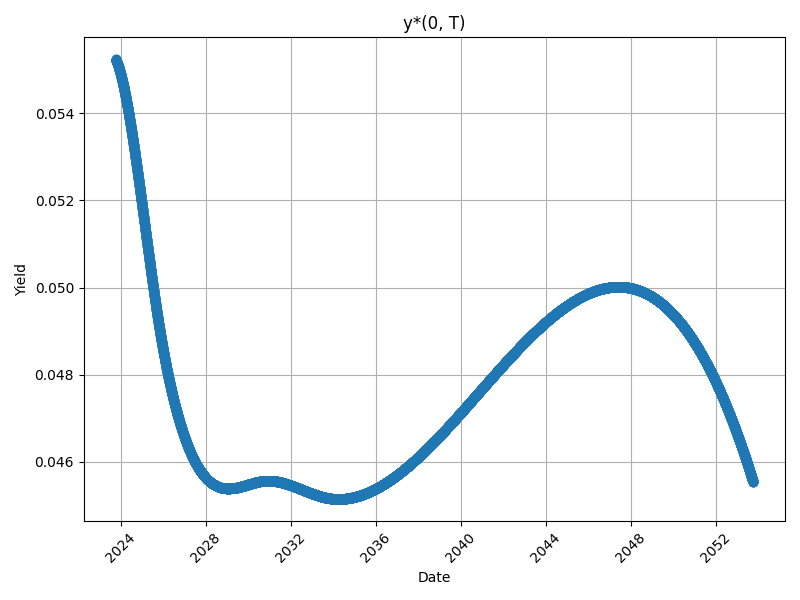

In [11]:
plt.figure()
plt.plot(df_ycs['Date'], df_ycs['Yield'], marker='o', linestyle='-')
plt.title('y*(0, T)')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
df_ycs['Maturity'] = (df_ycs['Date'] - df_ycs['Date'].min()).dt.days / 365.0 # We convert the time difference to a common unit of years
df_ycs['Forward Rate'] = np.log(df_ycs['Yield'] / df_ycs['Yield'].shift(1)) / (df_ycs['Maturity'] - df_ycs['Maturity'].shift(1))
df_ycs.head()

,Date,Yield,Maturity,Forward Rate
0,2023-10-02,0.055240,0.000000,NaN
1,2023-10-03,0.055237,0.002740,-0.018940
2,2023-10-04,0.055234,0.005479,-0.019131
3,2023-10-05,0.055231,0.008219,-0.019321
4,2023-10-06,0.055229,0.010959,-0.019510


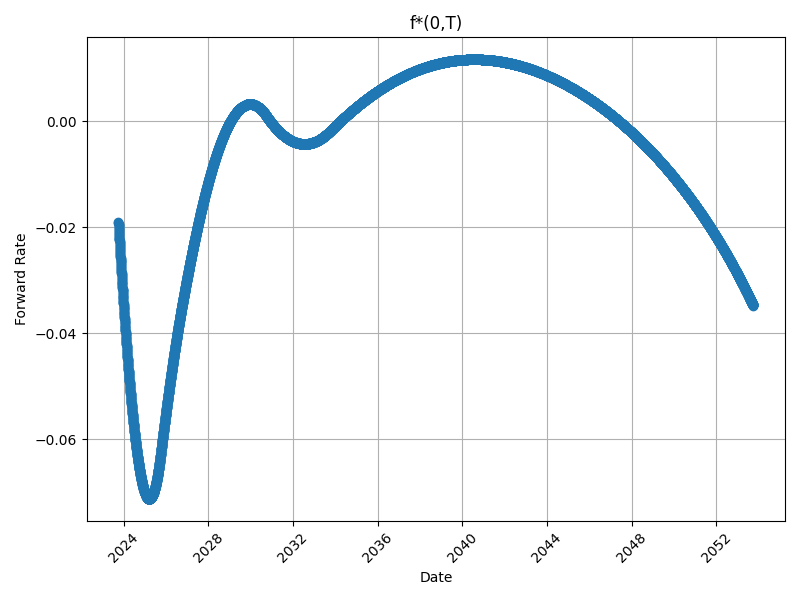

In [12]:
plt.figure()
plt.plot(df_ycs['Date'], df_ycs['Forward Rate'], marker='o', linestyle='-')
plt.title('f*(0,T)')
plt.xlabel('Date')
plt.ylabel('Forward Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
df_ycs['P*(0, T)'] = np.exp(-df_ycs['Maturity'] * df_ycs['Forward Rate'])

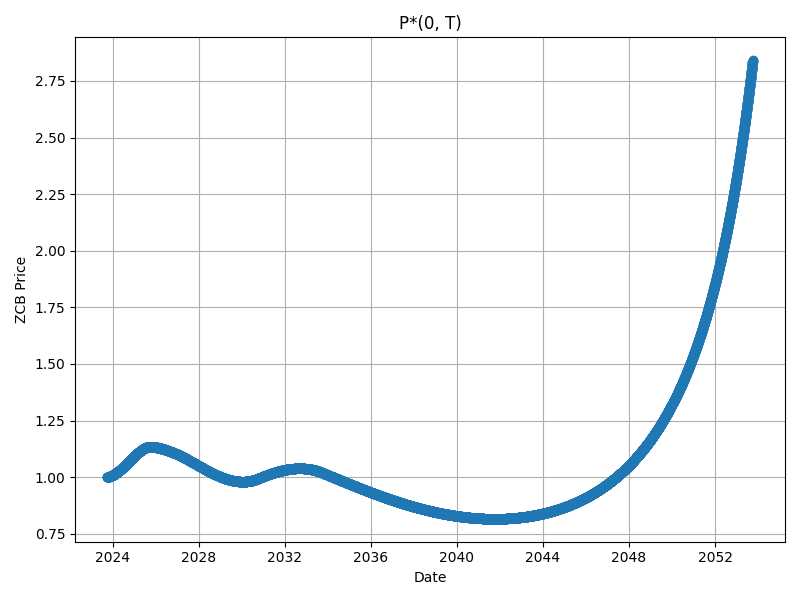

In [13]:
plt.figure()
plt.plot(df_ycs['Date'], df_ycs['P*(0, T)'], marker='o', linestyle='-', label='P*(0, T)')
plt.title('P*(0, T)')
plt.xlabel('Date')
plt.ylabel('ZCB Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# (b) Express Θ(t) in terms of the forward rate curve and plot it.

In [15]:
# Given by Assignment
alpha = 0.10  # 10%
sigma = 0.01  # 1%

df_ycs['Theta'] = alpha * df_ycs['Forward Rate'] + (sigma * df_ycs['Forward Rate'].diff())/(df_ycs['Maturity']-df_ycs['Maturity'].shift(1))


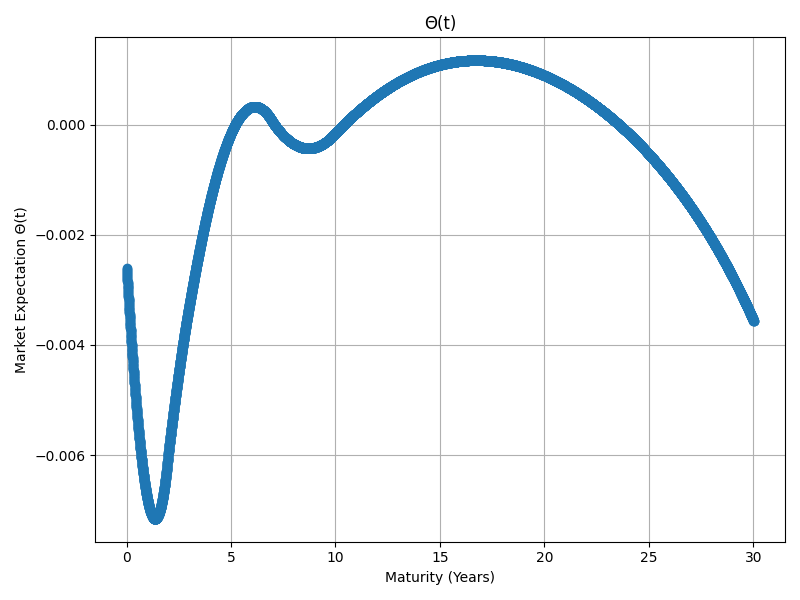

In [17]:
plt.figure()
plt.plot(df_ycs['Maturity'], df_ycs['Theta'], marker='o', linestyle='-')
plt.title('Θ(t)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Market Expectation Θ(t)')
plt.grid(True)
plt.tight_layout()
plt.show()